In [28]:
import matplotlib
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import re
from datetime import datetime


%matplotlib inline
    


%matplotlib inline
url1 = "https://raw.githubusercontent.com/docju/datasciencecapstone/main/results.csv"
download1 = requests.get(url1).content

df = pd.read_csv(io.StringIO(download1.decode('ISO-8859-1')))
df['date']=pd.to_datetime(df['DateTime'])
df['outcome']=df['FTHG']-df['FTAG']

def result(n):
    if n >0:
        res=1
    if n==0:
        res=0
    if n<0:
        res=-1
    return res

def result_1(n):
    if n==1:
        res=3
    if n==0:
        res=1
    if n==-1:
        res=0
    return res

df['result']=df.apply(lambda x: result(x['outcome']),axis=1)
all_results=df[['Season','date','HomeTeam','AwayTeam','FTHG','FTAG','outcome','result']][~df['Season'].isin(['2020-21','2021-22'])]

print(all_results.head())

    Season       date     HomeTeam        AwayTeam  FTHG  FTAG  outcome  \
0  1993-94 1993-08-14      Arsenal        Coventry     0     3       -3   
1  1993-94 1993-08-14  Aston Villa             QPR     4     1        3   
2  1993-94 1993-08-14      Chelsea       Blackburn     1     2       -1   
3  1993-94 1993-08-14    Liverpool  Sheffield Weds     2     0        2   
4  1993-94 1993-08-14     Man City           Leeds     1     1        0   

   result  
0      -1  
1       1  
2      -1  
3       1  
4       0  


In [29]:
#keep most recent entry

#all_results.groupby(["HomeTeam","AwayTeam"], as_index=False).max()
teams=all_results[all_results['Season']!='2019-20']['HomeTeam'].unique()

#keep only most recent entry
most_recent=all_results[all_results['Season']!='2019-20'].sort_values('date').drop_duplicates(['HomeTeam','AwayTeam'],keep='last')
#keep average of all previous results
average_results=all_results[all_results['Season']!='2019-20'].groupby(['HomeTeam','AwayTeam']).mean()['result'].reset_index()

most_recent_matrix=np.asmatrix(most_recent.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack().fillna(0))
average_result_matrix=np.asmatrix(average_results.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack().fillna(0))


def table_create(scores=most_recent):
    #period=scores[all_results['Season']==season].copy()
    period=scores.copy()
    period['home_points']=period.apply(lambda x: result_1(x['result']),axis=1)
    period['away_points']=period.apply(lambda x: result_1(-1*x['result']),axis=1)
    period['home_gd']=period['outcome']
    period['away_gd']=-1*period['outcome']
    period['home_games']=1
    period['away_games']=1
    home_games=period.groupby('HomeTeam').sum()['home_games']
    away_games=period.groupby('AwayTeam').sum()['away_games']
    home_sum=period.groupby('HomeTeam').sum()['home_points']
    away_sum=period.groupby('AwayTeam').sum()['away_points']
    home_gd=period.groupby('HomeTeam').sum()['home_gd']
    away_gd=period.groupby('AwayTeam').sum()['away_gd']
    home_goals=period.groupby('HomeTeam').sum()['FTHG']
    away_goals=period.groupby('AwayTeam').sum()['FTAG']
    points_total=pd.concat([home_games,away_games,home_sum,away_sum, home_gd,away_gd,home_goals,away_goals],axis=1)
    points_total.index.name='Team'
    points_total=points_total.reset_index()
    points_total['Played']=points_total['home_games']+points_total['away_games']
    points_total['GF']=points_total['FTHG']+points_total['FTAG']
    points_total['GD']=points_total['home_gd']+points_total['away_gd']
    points_total['Points']=points_total['home_points']+points_total['away_points']
    points_total=points_total[['Team','Played','GF','GD','Points']].sort_values(['Points','GD','GF','Team'],ascending=[False,False,False,True])   
    
    return points_total


def split_season_train_test (test,input_df):
    '''
    This function takes data from a particular season and splits it into training and test samples
    
    INPUT:
    input_df - (dataframe) input matrix containing results of all seasons
    season - (string) season to split
    test - (int) number of rows that constitute the test data frame
    
    OUTPUT:
    season_train - (dataframe) a dataframe containing only the non-test rows
    season_test - (dataframe) a dataframe containing the test rows
    '''
    train=input_df.shape[0]-test
    season_train=input_df.copy().head(train)
    season_test=input_df.copy().tail(test)

    return season_train, season_test

train,test=split_season_train_test(92,most_recent)




In [3]:
# Perform SVD on the User-Item Matrix Here

u_rec, s_rec, vt_rec =np.linalg.svd(most_recent_matrix)
u_ave, s_ave, vt_ave =np.linalg.svd(average_result_matrix)


print(u_rec.shape,s_rec.shape, vt_rec.shape)# use the built in to get the three matrices

print(u_ave.shape,s_ave.shape, vt_ave.shape)# use the built in to get the three matrices

(49, 49) (49,) (49, 49)
(49, 49) (49,) (49, 49)


(49, 49) (49,) (49, 49)
(49, 49) (49,) (49, 49)


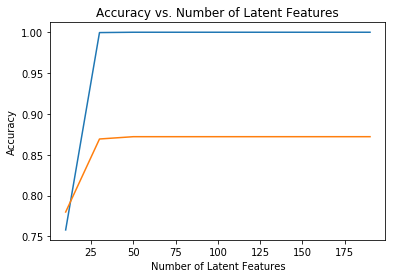

In [4]:
# Perform SVD on the User-Item Matrix Here

u_rec, s_rec, vt_rec =np.linalg.svd(most_recent_matrix)
u_ave, s_ave, vt_ave =np.linalg.svd(average_result_matrix)


print(u_rec.shape,s_rec.shape, vt_rec.shape)# use the built in to get the three matrices

print(u_ave.shape,s_ave.shape, vt_ave.shape)# use the built in to get the three matrices


num_latent_feats = np.arange(10,200+10,20)
sum_errs = []
sum_errs_ave=[]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_rec[:k]), u_rec[:, :k], vt_rec[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(most_recent_matrix, user_item_est)
    for l in range(0,most_recent_matrix.shape[0]):
        for m in range(0,most_recent_matrix.shape[0]):
            if l==m:
                diffs[l,m]=0 #not interested in diagonal entries
         
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
for j in num_latent_feats:
    # restructure with k latent features
    s_new_ave, u_new_ave, vt_new_ave = np.diag(s_ave[:j]), u_ave[:, :j], vt_ave[:j, :]
    
    # take dot product
    user_item_est_ave = np.around(np.dot(np.dot(u_new_ave, s_new_ave), vt_new_ave))
    
    # compute error for each prediction to actual value
    diffs_ave = np.subtract(average_result_matrix, user_item_est_ave)
    for l in range(0,average_result_matrix.shape[0]):
        for m in range(0,average_result_matrix.shape[0]):
            if l==m:
                diffs_ave[l,m]=0 #not interested in diagonal entries
    
    # total errors and keep track of them
    err_ave = np.sum(np.sum(np.abs(diffs_ave)))
    sum_errs_ave.append(err_ave)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(most_recent_matrix.shape[0]*most_recent_matrix.shape[1]));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_ave)/(average_result_matrix.shape[0]*average_result_matrix.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [24]:
def split_season_train_test (test,input_df):
    '''
    This function takes data from a particular season and splits it into training and test samples
    
    INPUT:
    input_df - (dataframe) input matrix containing results of all seasons
    season - (string) season to split
    test - (int) number of rows that constitute the test data frame
    
    OUTPUT:
    season_train - (dataframe) a dataframe containing only the non-test rows
    season_test - (dataframe) a dataframe containing the test rows
    '''
    train=input_df.shape[0]-test
    season_train=input_df.copy().head(train)
    season_test=input_df.copy().tail(test)
    average_results_train=season_train.groupby(['HomeTeam','AwayTeam']).mean()['result'].reset_index()
    season_train_mat=season_train.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack().fillna(0)
    season_train_mat_ave=average_results_train.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack().fillna(0)
    season_test_mat=season_test.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack().fillna(0)
    season_train_mat_na=np.asmatrix(season_train.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack())
    season_test_mat_na=np.asmatrix(season_test.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack())
    average_train_mat_na=np.asmatrix(average_results_train.groupby(['HomeTeam', 'AwayTeam'])['result'].max().unstack())
    

    return season_train_mat, season_test_mat,season_train_mat_na,season_test_mat_na,season_train_mat_ave,average_train_mat_na

train_rec,test_rec,train_rec_na,test_rec_na,train_rec_ave,ave_na=split_season_train_test(92,most_recent)



AwayTeam          Arsenal  Aston Villa  Barnsley  Birmingham  Blackburn  \
HomeTeam                                                                  
Arsenal               0.0          1.0       1.0         1.0        1.0   
Aston Villa          -1.0          0.0      -1.0         0.0        1.0   
Barnsley             -1.0         -1.0       0.0         0.0        0.0   
Birmingham           -1.0          0.0       0.0         0.0        1.0   
Blackburn             1.0          0.0       1.0         0.0        0.0   
Blackpool            -1.0          0.0       0.0        -1.0       -1.0   
Bolton                0.0         -1.0       0.0         0.0        1.0   
Bournemouth          -1.0         -1.0       0.0         0.0        0.0   
Bradford              0.0         -1.0       0.0         0.0        0.0   
Brighton              0.0          0.0       0.0         0.0        0.0   
Burnley               0.0          0.0       0.0         1.0       -1.0   
Cardiff              -1.0

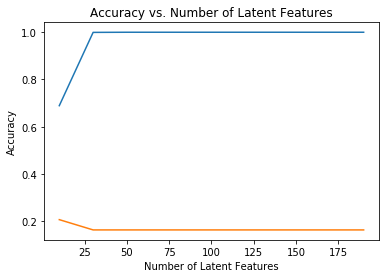

In [72]:
u_train_rec, s_train_rec, vt_train_rec = np.linalg.svd(train_rec)# fit svd similar to above then use the cells below
u_train_rec.shape,s_train_rec.shape,vt_train_rec.shape

teams_mod=all_results[all_results['Season']=='2018-19']['HomeTeam'].unique()

#run SVD on train dataset
u_train_rec, s_train_rec, vt_train_rec = np.linalg.svd(train_rec)
#keep on data in decomposed matrices that fits both
row_idx=train_rec.index.isin(teams_mod)
col_idx=train_rec.columns.isin(teams_mod)


# See how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,200+10,20)
sum_errs = []
sum_errs_test=[]


for k in num_latent_feats:
   
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train_rec[:k]), u_train_rec[:, :k], vt_train_rec[:k, :]
    
    # take dot product
    u_test = u_new[row_idx, :k]
    vt_test = vt_new[:k, col_idx]

    
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test, s_new), vt_test))
   
    # compute error for each prediction to actual value
    diffs = np.asmatrix(np.subtract(train_rec, user_item_est_train))
    for l in range(0,train_rec.shape[0]):
        for m in range(0,train_rec.shape[1]):
            if l==m:
                diffs[l,m]=0 #not interested in diagonal entries
            elif math.isnan(train_rec_na[l,m]) is True:
                diffs[l,m]=0 #not interested in errors where we had no data originally
            
    diffs_test = np.asmatrix(np.subtract(test_rec, user_item_est_test))
    for l in range(0,test_rec.shape[0]):
        for m in range(0,test_rec.shape[1]):
            if l==m:
                diffs_test[l,m]=0 #not interested in diagonal entries
            elif math.isnan(test_rec_na[l,m]) is True:
                diffs_test[l,m]=0 #not interested in errors where we had no data originally
            
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(np.count_nonzero(~np.isnan(train_rec_na))));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(np.count_nonzero(~np.isnan(test_rec_na))));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


In [74]:
#only use most recent season

train_rec,test_rec,train_rec_na,test_rec_na,train_rec_ave_not=split_season_train_test(92,most_recent[most_recent['Season']=='2018-19'])

u_train_rec, s_train_rec, vt_train_rec = np.linalg.svd(train_rec)# fit svd similar to above then use the cells below
u_train_rec.shape,s_train_rec.shape,vt_train_rec.shape

#teams_mod=all_results[all_results['Season']=='2018-19']['HomeTeam'].unique()

#run SVD on train dataset
u_train_rec, s_train_rec, vt_train_rec = np.linalg.svd(train_rec)
#keep on data in decomposed matrices that fits both
row_idx=train_rec.index.isin(teams_mod)
col_idx=train_rec.columns.isin(teams_mod)


# See how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,200+10,20)
sum_errs = []
sum_errs_test=[]


for k in num_latent_feats:
   
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train_rec[:k]), u_train_rec[:, :k], vt_train_rec[:k, :]
    
    # take dot product
    u_test = u_new[row_idx, :k]
    vt_test = vt_new[:k, col_idx]

    
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test, s_new), vt_test))
   
    # compute error for each prediction to actual value
    diffs = np.asmatrix(np.subtract(train_rec, user_item_est_train))
    for l in range(0,train_rec.shape[0]):
        for m in range(0,train_rec.shape[1]):
            if l==m:
                diffs[l,m]=0 #not interested in diagonal entries
            elif math.isnan(train_rec_na[l,m]) is True:
                diffs[l,m]=0 #not interested in errors where we had no data originally
            
    diffs_test = np.asmatrix(np.subtract(test_rec, user_item_est_test))
    for l in range(0,test_rec.shape[0]):
        for m in range(0,test_rec.shape[1]):
            if l==m:
                diffs_test[l,m]=0 #not interested in diagonal entries
            elif math.isnan(test_rec_na[l,m]) is True:
                diffs_test[l,m]=0 #not interested in errors where we had no data originally
            
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(np.count_nonzero(~np.isnan(train_rec_na))));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(np.count_nonzero(~np.isnan(test_rec_na))));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


ValueError: not enough values to unpack (expected 5, got 2)

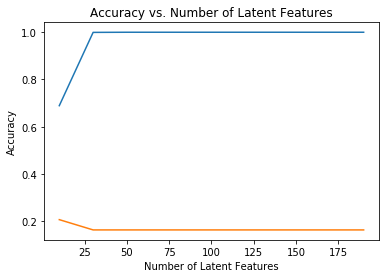

In [25]:



#run SVD on train dataset
u_train_ave, s_train_ave, vt_train_ave = np.linalg.svd(train_rec_ave)
#keep on data in decomposed matrices that fits both
row_idx=train_rec_ave.index.isin(teams_mod)
col_idx=train_rec_ave.columns.isin(teams_mod)


# See how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,200+10,20)
sum_errs = []
sum_errs_test=[]




for k in num_latent_feats:
   
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train_ave[:k]), u_train_ave[:, :k], vt_train_ave[:k, :]
    
    # take dot product
    u_test = u_new[row_idx, :k]
    vt_test = vt_new[:k, col_idx]

    
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test, s_new), vt_test))
   
    # compute error for each prediction to actual value
    diffs = np.asmatrix(np.subtract(train_rec_ave, user_item_est_train))
    for l in range(0,train_rec_ave.shape[0]):
        for m in range(0,train_rec_ave.shape[1]):
            if l==m:
                diffs[l,m]=0 #not interested in diagonal entries
            elif math.isnan(train_rec_na[l,m]) is True:
                diffs[l,m]=0 #not interested in errors where we had no data originally
            
    diffs_test = np.asmatrix(np.subtract(test_rec, user_item_est_test))
    for l in range(0,test_rec.shape[0]):
        for m in range(0,test_rec.shape[1]):
            if l==m:
                diffs_test[l,m]=0 #not interested in diagonal entries
            elif math.isnan(test_rec_na[l,m]) is True:
                diffs_test[l,m]=0 #not interested in errors where we had no data originally
            
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(np.count_nonzero(~np.isnan(ave_na))));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(np.count_nonzero(~np.isnan(test_rec_na))));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


In [76]:
print(table_create(all_results[all_results['Season']=='2018-19'].tail(92)))


              Team  Played  GF  GD  Points
11       Liverpool       9  25  18      27
12        Man City       9  19  16      27
10       Leicester      10  17   8      17
7          Everton       9  15   8      17
5          Chelsea      10  14   5      16
6   Crystal Palace       9  16   2      16
14       Newcastle       9  16   4      14
19          Wolves       9  10  -1      14
18        West Ham       9  15   1      13
0          Arsenal       9  12   0      13
15     Southampton       9  13  -3      12
1      Bournemouth       9  17   1      11
16       Tottenham       9  11   2      10
3          Burnley       9  13  -2      10
17         Watford      10  13  -6      10
4          Cardiff       9   9  -3       9
8           Fulham       9   7  -9       9
13      Man United       9   7  -9       8
2         Brighton      10   5 -14       6
9     Huddersfield       9   7 -18       2


In [75]:
result_matrix=user_item_est_test
home_results=result_matrix.copy()


for i in range(0,20):
    for j in range(0,20):
        if i==j: 
            home_results[i,j]=0
        elif i!=j and result_matrix[i,j]>=0:
            home_results[i,j]=1+2*result_matrix[i,j]
        elif i!=j and result_matrix[i,j]<0:
            home_results[i,j]=1+result_matrix[i,j]


def away_version(result_matrix):
    n=len(result_matrix)
    new_mat=result_matrix.copy()
    for i in range(n):
        for j in range(n):
            if i==j:
                new_mat[i,j]=0
            elif i!=j:
                new_mat[i,j]=-result_matrix[i,j]                
            
    new_mat_t=np.transpose(new_mat)
    return new_mat_t

away=away_version(result_matrix)
away_results=away.copy()

for i in range(0,20):
    for j in range(0,20):
        if i==j: 
            away_results[i,j]=0
        elif i!=j and away[i,j]>=0:
            away_results[i,j]=1+2*away[i,j]
        elif i!=j and away[i,j]<0:
            away_results[i,j]=1+away[i,j]
    
for i in range(0,20):
    for j in range(0,20):
      
        if np.isnan(test_rec_na[i,j]):
            home_results[i,j]=0
        if np.isnan(test_rec_na[j,i]):
            away_results[j,i]=0
print('-------')            
for i in range(0,20):
    print(sum(home_results[i]+away_results[i]))
                



-------
10.0
7.0
9.0
9.0
5.0
15.0
11.0
8.0
6.0
4.0
12.0
18.0
13.0
12.0
7.0
9.0
20.0
14.0
12.0
7.0
